In [1]:
# ============================================================================
# CELL 1: IMPORT LIBRARIES
# ============================================================================
"""
Import libraries untuk modeling dan evaluation.
"""

# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, 
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score,
    cohen_kappa_score, matthews_corrcoef
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import json
import os
import joblib
from datetime import datetime
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['savefig.dpi'] = 300

print("="*80)
print("✅ All libraries imported successfully!")
print("="*80)


✅ All libraries imported successfully!


In [2]:
# ============================================================================
# CELL 2: LOAD PROCESSED DATASETS
# ============================================================================
"""
Load train-test splits yang sudah diproses di Notebook 02.
"""

print("\n" + "="*80)
print("📂 LOADING PROCESSED DATASETS")
print("="*80)

# Load training data
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()

# Load test data
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print("\n✅ Datasets loaded successfully!")
print("-"*80)

print(f"\n📊 Training Set:")
print(f"   • X_train shape: {X_train.shape}")
print(f"   • y_train shape: {y_train.shape}")
print(f"   • Features: {X_train.shape[1]}")
print(f"   • Samples: {X_train.shape[0]}")

print(f"\n📊 Test Set:")
print(f"   • X_test shape: {X_test.shape}")
print(f"   • y_test shape: {y_test.shape}")
print(f"   • Features: {X_test.shape[1]}")
print(f"   • Samples: {X_test.shape[0]}")

# Verify feature names
print(f"\n📋 Feature Names ({len(X_train.columns)}):")
print(f"   {X_train.columns.tolist()}")

# Class distribution
train_dist = Counter(y_train)
test_dist = Counter(y_test)

print(f"\n🎯 Target Distribution:")
print(f"   Training: Class 0={train_dist[0]}, Class 1={train_dist[1]}")
print(f"   Test:     Class 0={test_dist[0]}, Class 1={test_dist[1]}")

# Data quality check
print(f"\n🔍 Data Quality Check:")
print(f"   • Missing in X_train: {X_train.isnull().sum().sum()}")
print(f"   • Missing in y_train: {np.isnan(y_train).sum()}")
print(f"   • Missing in X_test: {X_test.isnull().sum().sum()}")
print(f"   • Missing in y_test: {np.isnan(y_test).sum()}")

if X_train.isnull().sum().sum() == 0:
    print("   ✅ All datasets are clean!")


📂 LOADING PROCESSED DATASETS

✅ Datasets loaded successfully!
--------------------------------------------------------------------------------

📊 Training Set:
   • X_train shape: (1508, 24)
   • y_train shape: (1508,)
   • Features: 24
   • Samples: 1508

📊 Test Set:
   • X_test shape: (377, 24)
   • y_test shape: (377,)
   • Features: 24
   • Samples: 377

📋 Feature Names (24):
   ['Age_Encoded', 'Gender_Encoded', 'Education_Encoded', 'country_Australia', 'country_Canada', 'country_New Zealand', 'country_Other', 'country_Republic of Ireland', 'country_UK', 'country_USA', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Mixed-Black/Asian', 'ethnicity_Mixed-White/Asian', 'ethnicity_Mixed-White/Black', 'ethnicity_Other', 'ethnicity_White', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']

🎯 Target Distribution:
   Training: Class 0=568, Class 1=940
   Test:     Class 0=142, Class 1=235

🔍 Data Quality Check:
   • Missing in X_train: 0
   • Missing in y_train: 0
   •

In [3]:
# ============================================================================
# CELL 3: INITIALIZE BASELINE RANDOM FOREST
# ============================================================================
"""
Initialize Random Forest dengan default parameters untuk baseline.
"""

print("\n" + "="*80)
print("🌳 INITIALIZING BASELINE RANDOM FOREST")
print("="*80)

# Baseline parameters (scikit-learn defaults)
RANDOM_STATE = 42

rf_baseline = RandomForestClassifier(
    n_estimators=100,          # Default
    criterion='gini',          # Default
    max_depth=None,            # Default (unlimited)
    min_samples_split=2,       # Default
    min_samples_leaf=1,        # Default
    max_features='sqrt',       # Default for classification
    bootstrap=True,            # Default
    random_state=RANDOM_STATE,
    n_jobs=-1,                 # Use all CPU cores
    verbose=0
)

print("\n📋 Baseline Model Configuration:")
print("-"*80)
print(f"   • Model: Random Forest Classifier")
print(f"   • n_estimators: 100 (default)")
print(f"   • criterion: gini (default)")
print(f"   • max_depth: None (unlimited)")
print(f"   • min_samples_split: 2")
print(f"   • min_samples_leaf: 1")
print(f"   • max_features: sqrt")
print(f"   • bootstrap: True")
print(f"   • random_state: {RANDOM_STATE}")
print(f"   • n_jobs: -1 (all cores)")

print("\n✅ Baseline model initialized!")


🌳 INITIALIZING BASELINE RANDOM FOREST

📋 Baseline Model Configuration:
--------------------------------------------------------------------------------
   • Model: Random Forest Classifier
   • n_estimators: 100 (default)
   • criterion: gini (default)
   • max_depth: None (unlimited)
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: sqrt
   • bootstrap: True
   • random_state: 42
   • n_jobs: -1 (all cores)

✅ Baseline model initialized!


In [4]:
# ============================================================================
# CELL 4: TRAIN BASELINE MODEL
# ============================================================================
"""
Train baseline Random Forest pada training data.
"""

print("\n" + "="*80)
print("🎓 TRAINING BASELINE MODEL")
print("="*80)

# Record start time
start_time = datetime.now()
print(f"\n⏰ Training started: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Train model
print("\n🔄 Fitting Random Forest...")
rf_baseline.fit(X_train, y_train)

# Record end time
end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

print(f"✅ Training completed!")
print(f"⏱️  Training time: {training_time:.2f} seconds")

# Model info
print(f"\n📊 Model Information:")
print(f"   • Number of trees: {rf_baseline.n_estimators}")
print(f"   • Number of features: {rf_baseline.n_features_in_}")
print(f"   • Number of classes: {rf_baseline.n_classes_}")
print(f"   • Classes: {rf_baseline.classes_}")



🎓 TRAINING BASELINE MODEL

⏰ Training started: 2025-11-03 11:19:09

🔄 Fitting Random Forest...
✅ Training completed!
⏱️  Training time: 0.43 seconds

📊 Model Information:
   • Number of trees: 100
   • Number of features: 24
   • Number of classes: 2
   • Classes: [0 1]


In [5]:
# ============================================================================
# CELL 5: BASELINE PREDICTIONS
# ============================================================================
"""
Generate predictions pada training dan test sets.
"""

print("\n" + "="*80)
print("🔮 GENERATING PREDICTIONS")
print("="*80)

# Training predictions
print("\n📊 Training Set Predictions...")
y_train_pred = rf_baseline.predict(X_train)
y_train_pred_proba = rf_baseline.predict_proba(X_train)[:, 1]

print(f"   ✅ Generated {len(y_train_pred)} predictions")
print(f"   • Predicted Class 0: {(y_train_pred == 0).sum()}")
print(f"   • Predicted Class 1: {(y_train_pred == 1).sum()}")

# Test predictions
print("\n📊 Test Set Predictions...")
y_test_pred = rf_baseline.predict(X_test)
y_test_pred_proba = rf_baseline.predict_proba(X_test)[:, 1]

print(f"   ✅ Generated {len(y_test_pred)} predictions")
print(f"   • Predicted Class 0: {(y_test_pred == 0).sum()}")
print(f"   • Predicted Class 1: {(y_test_pred == 1).sum()}")

# Probability statistics
print(f"\n📈 Prediction Probability Statistics (Test Set):")
print(f"   • Min probability: {y_test_pred_proba.min():.4f}")
print(f"   • Max probability: {y_test_pred_proba.max():.4f}")
print(f"   • Mean probability: {y_test_pred_proba.mean():.4f}")
print(f"   • Median probability: {np.median(y_test_pred_proba):.4f}")


🔮 GENERATING PREDICTIONS

📊 Training Set Predictions...
   ✅ Generated 1508 predictions
   • Predicted Class 0: 568
   • Predicted Class 1: 940

📊 Test Set Predictions...
   ✅ Generated 377 predictions
   • Predicted Class 0: 149
   • Predicted Class 1: 228

📈 Prediction Probability Statistics (Test Set):
   • Min probability: 0.0200
   • Max probability: 1.0000
   • Mean probability: 0.6232
   • Median probability: 0.6900



📊 CONFUSION MATRIX ANALYSIS

🔢 Confusion Matrix - Training Set:
--------------------------------------------------------------------------------
                Predicted
               Non-User  User
Actual Non-User   568       0
       User         0     940

🔢 Confusion Matrix - Test Set:
--------------------------------------------------------------------------------
                Predicted
               Non-User  User
Actual Non-User   120      22
       User        29     206


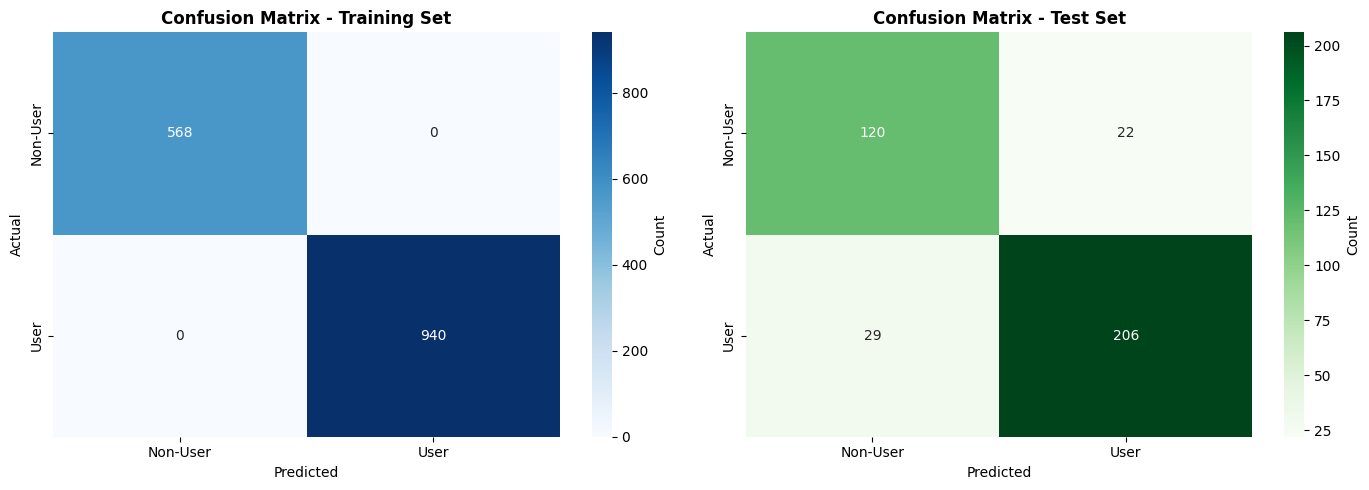


✅ Confusion matrices visualized!


In [6]:
# ============================================================================
# CELL 6: CONFUSION MATRIX
# ============================================================================
"""
Calculate dan visualize confusion matrix untuk training dan test sets.
"""

print("\n" + "="*80)
print("📊 CONFUSION MATRIX ANALYSIS")
print("="*80)

# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("\n🔢 Confusion Matrix - Training Set:")
print("-"*80)
print(f"                Predicted")
print(f"               Non-User  User")
print(f"Actual Non-User  {cm_train[0, 0]:4d}    {cm_train[0, 1]:4d}")
print(f"       User      {cm_train[1, 0]:4d}    {cm_train[1, 1]:4d}")

print("\n🔢 Confusion Matrix - Test Set:")
print("-"*80)
print(f"                Predicted")
print(f"               Non-User  User")
print(f"Actual Non-User  {cm_test[0, 0]:4d}    {cm_test[0, 1]:4d}")
print(f"       User      {cm_test[1, 0]:4d}    {cm_test[1, 1]:4d}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-User', 'User'],
            yticklabels=['Non-User', 'User'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Training Set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=10)
axes[0].set_xlabel('Predicted', fontsize=10)

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-User', 'User'],
            yticklabels=['Non-User', 'User'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=10)
axes[1].set_xlabel('Predicted', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/19_baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrices visualized!")

In [7]:
# ============================================================================
# CELL 7: COMPREHENSIVE EVALUATION METRICS
# ============================================================================
"""
Calculate comprehensive evaluation metrics untuk baseline model.
"""

print("\n" + "="*80)
print("📏 COMPREHENSIVE EVALUATION METRICS")
print("="*80)

def calculate_metrics(y_true, y_pred, y_pred_proba, set_name=""):
    """Calculate comprehensive metrics"""
    
    # Confusion matrix elements
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)  # Sensitivity
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Balanced accuracy
    balanced_acc = (recall + specificity) / 2
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # PR-AUC (important for imbalanced data)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true, y_pred)
    
    metrics = {
        'Set': set_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        'True Positives': int(tp),
        'True Negatives': int(tn),
        'False Positives': int(fp),
        'False Negatives': int(fn)
    }
    
    return metrics

# Calculate metrics for both sets
print("\n🔢 Calculating metrics...")

train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_proba, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba, "Test")

# Create comparison DataFrame
metrics_df = pd.DataFrame([train_metrics, test_metrics]).set_index('Set')

print("\n📊 BASELINE MODEL PERFORMANCE:")
print("="*80)
display(metrics_df[['Accuracy', 'Precision', 'Recall (Sensitivity)', 
                     'Specificity', 'F1-Score', 'Balanced Accuracy',
                     'ROC-AUC', 'PR-AUC', 'Cohen Kappa', 'MCC']].round(4))

print("\n📊 CONFUSION MATRIX BREAKDOWN:")
print("="*80)
display(metrics_df[['True Positives', 'True Negatives', 
                     'False Positives', 'False Negatives']])

# Highlight key findings
print("\n🎯 KEY FINDINGS:")
print("-"*80)
print(f"Test Set Performance:")
print(f"   • Accuracy: {test_metrics['Accuracy']:.4f} ({test_metrics['Accuracy']*100:.2f}%)")
print(f"   • ROC-AUC: {test_metrics['ROC-AUC']:.4f}")
print(f"   • F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"   • Balanced Accuracy: {test_metrics['Balanced Accuracy']:.4f}")

# Check for overfitting
train_test_gap = train_metrics['Accuracy'] - test_metrics['Accuracy']
if train_test_gap > 0.05:
    print(f"\n⚠️  Overfitting detected:")
    print(f"   • Train-Test gap: {train_test_gap:.4f}")
    print(f"   • Training accuracy: {train_metrics['Accuracy']:.4f}")
    print(f"   • Test accuracy: {test_metrics['Accuracy']:.4f}")
else:
    print(f"\n✅ No significant overfitting:")
    print(f"   • Train-Test gap: {train_test_gap:.4f}")



📏 COMPREHENSIVE EVALUATION METRICS

🔢 Calculating metrics...

📊 BASELINE MODEL PERFORMANCE:


,Accuracy,Precision,Recall (Sensitivity),Specificity,F1-Score,Balanced Accuracy,ROC-AUC,PR-AUC,Cohen Kappa,MCC
Set,,,,,,,,,,
Training,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Test,0.8647,0.9035,0.8766,0.8451,0.8898,0.8608,0.9271,0.9577,0.7147,0.7152



📊 CONFUSION MATRIX BREAKDOWN:


,True Positives,True Negatives,False Positives,False Negatives
Set,,,,
Training,940,568,0,0
Test,206,120,22,29



🎯 KEY FINDINGS:
--------------------------------------------------------------------------------
Test Set Performance:
   • Accuracy: 0.8647 (86.47%)
   • ROC-AUC: 0.9271
   • F1-Score: 0.8898
   • Balanced Accuracy: 0.8608

⚠️  Overfitting detected:
   • Train-Test gap: 0.1353
   • Training accuracy: 1.0000
   • Test accuracy: 0.8647


In [8]:
# ============================================================================
# CELL 8: CLASSIFICATION REPORT
# ============================================================================
"""
Generate detailed classification report.
"""

print("\n" + "="*80)
print("📋 CLASSIFICATION REPORT")
print("="*80)

print("\n🔢 Training Set:")
print("-"*80)
print(classification_report(y_train, y_train_pred, 
                          target_names=['Non-User (0)', 'User (1)'],
                          digits=4))

print("\n🔢 Test Set:")
print("-"*80)
print(classification_report(y_test, y_test_pred,
                          target_names=['Non-User (0)', 'User (1)'],
                          digits=4))


📋 CLASSIFICATION REPORT

🔢 Training Set:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

Non-User (0)     1.0000    1.0000    1.0000       568
    User (1)     1.0000    1.0000    1.0000       940

    accuracy                         1.0000      1508
   macro avg     1.0000    1.0000    1.0000      1508
weighted avg     1.0000    1.0000    1.0000      1508


🔢 Test Set:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

Non-User (0)     0.8054    0.8451    0.8247       142
    User (1)     0.9035    0.8766    0.8898       235

    accuracy                         0.8647       377
   macro avg     0.8544    0.8608    0.8573       377
weighted avg     0.8665    0.8647    0.8653       377




📈 ROC CURVE ANALYSIS

📊 ROC-AUC Scores:
   • Training Set: 1.0000
   • Test Set: 0.9271


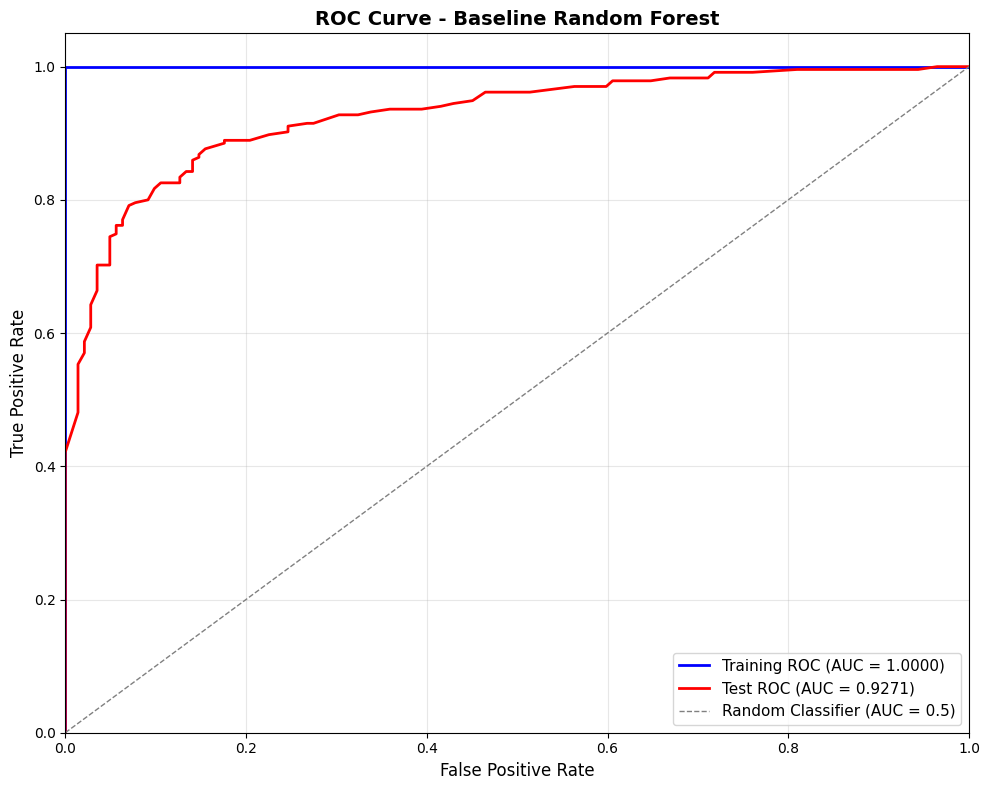


✅ ROC curves plotted!


In [9]:
# ============================================================================
# CELL 9: ROC CURVE ANALYSIS
# ============================================================================
"""
Plot ROC curve dan calculate AUC untuk training dan test sets.
"""

print("\n" + "="*80)
print("📈 ROC CURVE ANALYSIS")
print("="*80)

# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

print(f"\n📊 ROC-AUC Scores:")
print(f"   • Training Set: {roc_auc_train:.4f}")
print(f"   • Test Set: {roc_auc_test:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Training ROC
plt.plot(fpr_train, tpr_train, color='blue', lw=2, 
         label=f'Training ROC (AUC = {roc_auc_train:.4f})')

# Test ROC
plt.plot(fpr_test, tpr_test, color='red', lw=2,
         label=f'Test ROC (AUC = {roc_auc_test:.4f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/20_baseline_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ROC curves plotted!")


📈 PRECISION-RECALL CURVE ANALYSIS

📊 PR-AUC Scores:
   • Training Set: 1.0000
   • Test Set: 0.9577


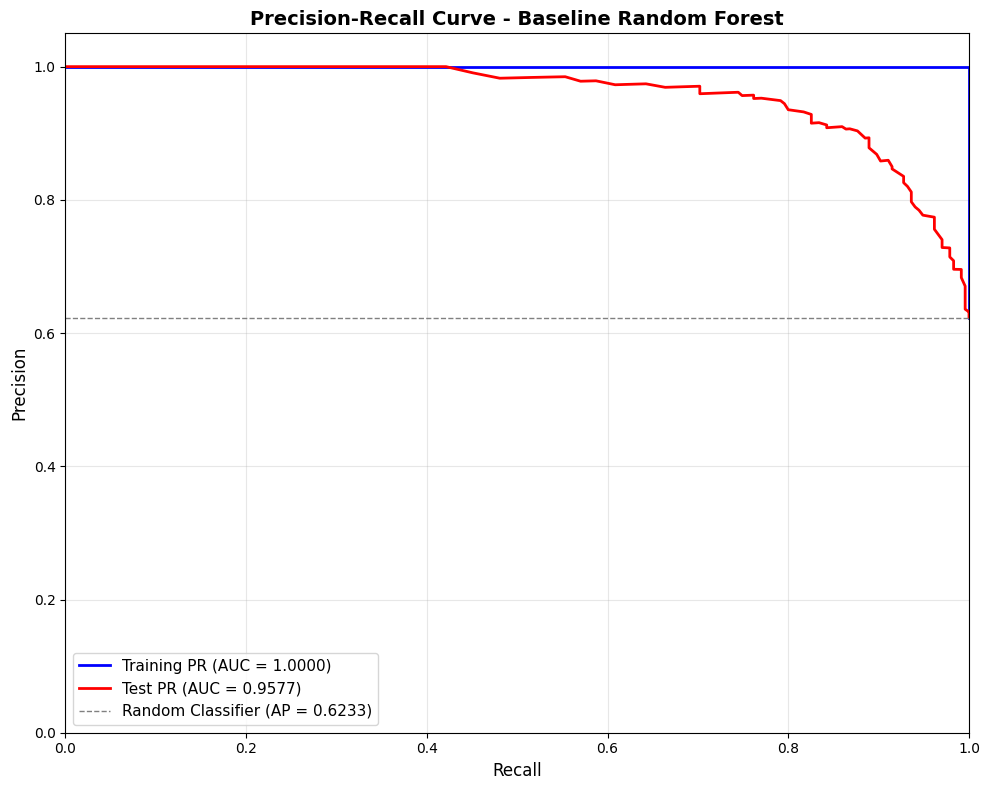


✅ PR curves plotted!

📌 Note: PR curves are more informative than ROC for imbalanced datasets


In [10]:
# ============================================================================
# CELL 10: PRECISION-RECALL CURVE
# ============================================================================
"""
Plot Precision-Recall curve (important untuk imbalanced data).
"""

print("\n" + "="*80)
print("📈 PRECISION-RECALL CURVE ANALYSIS")
print("="*80)

# Calculate PR curves
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
pr_auc_train = average_precision_score(y_train, y_train_pred_proba)

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc_test = average_precision_score(y_test, y_test_pred_proba)

print(f"\n📊 PR-AUC Scores:")
print(f"   • Training Set: {pr_auc_train:.4f}")
print(f"   • Test Set: {pr_auc_test:.4f}")

# Baseline (random classifier performance)
baseline_pr = (y_test == 1).sum() / len(y_test)

# Plot PR curves
plt.figure(figsize=(10, 8))

# Training PR
plt.plot(recall_train, precision_train, color='blue', lw=2,
         label=f'Training PR (AUC = {pr_auc_train:.4f})')

# Test PR
plt.plot(recall_test, precision_test, color='red', lw=2,
         label=f'Test PR (AUC = {pr_auc_test:.4f})')

# Baseline
plt.axhline(y=baseline_pr, color='gray', linestyle='--', lw=1,
            label=f'Random Classifier (AP = {baseline_pr:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Baseline Random Forest', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/21_baseline_pr_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ PR curves plotted!")
print("\n📌 Note: PR curves are more informative than ROC for imbalanced datasets")



🔄 CROSS-VALIDATION ANALYSIS

⚙️  CV Configuration:
   • Method: Stratified K-Fold
   • Number of folds: 5
   • Metrics: accuracy, precision, recall, f1, roc_auc

🔄 Running cross-validation...
   ✅ accuracy: 0.8269 (±0.0056)
   ✅ precision: 0.8665 (±0.0106)
   ✅ recall: 0.8543 (±0.0104)
   ✅ f1: 0.8602 (±0.0043)
   ✅ roc_auc: 0.8940 (±0.0054)

📊 Cross-Validation Summary:


,Metric,Mean Score,Std Dev,Min Score,Max Score
0,Accuracy,0.8269,0.0056,0.8179,0.8344
1,Precision,0.8665,0.0106,0.8519,0.8791
2,Recall,0.8543,0.0104,0.8404,0.8723
3,F1,0.8602,0.0043,0.8541,0.8654
4,Roc_auc,0.8940,0.0054,0.8874,0.9015


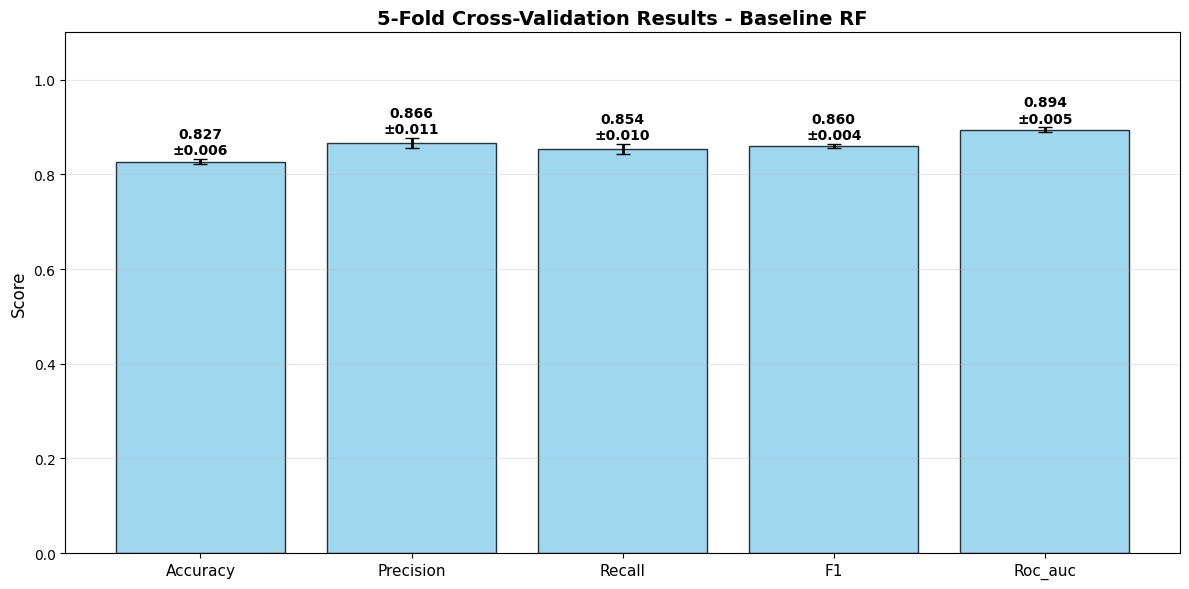


✅ Cross-validation completed!


In [ ]:
# ============================================================================
# CELL 11: CROSS-VALIDATION ANALYSIS
# ============================================================================
"""
Perform 5-fold stratified cross-validation pada training set.
"""

print("\n" + "="*80)
print("🔄 CROSS-VALIDATION ANALYSIS")
print("="*80)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print(f"\n⚙️  CV Configuration:")
print(f"   • Method: Stratified K-Fold")
print(f"   • Number of folds: 5")
print(f"   • Metrics: {', '.join(scoring_metrics)}")

cv_results = {}

print(f"\n🔄 Running cross-validation...")
for metric in scoring_metrics:
    scores = cross_val_score(rf_baseline, X_train, y_train, 
                            cv=cv, scoring=metric, n_jobs=-1)
    cv_results[metric] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"   ✅ {metric}: {scores.mean():.4f} (±{scores.std():.4f})")

# Create CV results DataFrame
cv_df = pd.DataFrame({
    'Metric': [m.capitalize() for m in scoring_metrics],
    'Mean Score': [cv_results[m]['mean'] for m in scoring_metrics],
    'Std Dev': [cv_results[m]['std'] for m in scoring_metrics],
    'Min Score': [cv_results[m]['scores'].min() for m in scoring_metrics],
    'Max Score': [cv_results[m]['scores'].max() for m in scoring_metrics]
})

print("\n📊 Cross-Validation Summary:")
print("="*80)
display(cv_df.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

metrics_labels = [m.capitalize() for m in scoring_metrics]
means = [cv_results[m]['mean'] for m in scoring_metrics]
stds = [cv_results[m]['std'] for m in scoring_metrics]

x_pos = np.arange(len(metrics_labels))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.8,
              color='skyblue', edgecolor='black', error_kw={'linewidth': 2})

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 0.01, f'{mean:.3f}\n±{std:.3f}',
            ha='center', fontsize=10, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results - Baseline RF', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_labels, fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/22_baseline_cv_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Cross-validation completed!")